In [193]:
from scipy import io
import os
import matplotlib.pyplot as plt
import pprint
import matplotlib.pyplot as plt
import time
from numpy.linalg import inv
import numpy as np
from scipy.spatial.transform import Rotation as R

In [194]:
from math import gamma
from matplotlib import markers
from matplotlib.markers import MarkerStyle
from numpy import shape
from sympy import euler


class calculatePose:
    def __init__(
        self, viconDataPath: str, imuDataPath: str, imuParamPath: str, setName: str
    ) -> None:
        """Calculate Pose based on IMU Data using Vicon As Ground Truth.
        The Task at hand is to read data from .mat file,
        Align time stamp of the IMU Data to Vicon Data TS,
        Calculate Orientation Based on:
            1. Gyroscope Data Only
            2. Accelerometer Data Only
            3. Complimentaty Filter using Gyroscope and Accelerometer
        Compare the Performance of each Mode

        Args:
            viconDataPath (str): Path where Vicon Data is saved
            imuDataPath (str): Path where IMU Data is saved
            imuParamPath (str): Path where IMU Accelerometer Params are saved
            setName (str): Name of the Set
        """
        viconDataLoader = io.loadmat(viconDataPath)
        viconTS = viconDataLoader["ts"]
        viconTS = viconTS[0]
        viconData = viconDataLoader["rots"]
        # print(viconTS)

        # Rotation Matrix with Z-Y-X Euler Angles Rotation
        imuDataLoader = io.loadmat(imuDataPath)
        IMUTS = imuDataLoader["ts"]
        IMUTS = IMUTS[0]
        IMUData = imuDataLoader["vals"]  # [ax ay az wz wx wy]^T
        # pprint.pprint(IMUTS)
        # pprint.pprint(IMUData)

        imuParamLoader = io.loadmat(imuParamPath)
        imuParams = imuParamLoader["IMUParams"]

        self.biasIterationCount = 300
        self.performIMUAttitudeEstimation(
            IMUTS, IMUData, imuParams, viconTS, viconData, setName
        )

    def calculateRawGyroBias(self, IMUData):
        """Calculate Gyroscope Bias using first N iterations

        Args:
            IMUData (np.array): NP Array of IMU Data [ax,ay,az,wz,wx,wy]

        Returns:
            tuple(float, float, float): bgx, bgy, bgz -> Gyroscope Bias in RAW Values
        """
        wxTotal = 0
        wyTotal = 0
        wzTotal = 0
        totalIterations = self.biasIterationCount
        for i in range(totalIterations):
            _, _, _, wz, wx, wy = IMUData[:, i]
            wxTotal += wx
            wyTotal += wy
            wzTotal += wz
        bgx = wxTotal / totalIterations
        bgy = wyTotal / totalIterations
        bgz = wzTotal / totalIterations
        return bgx, bgy, bgz

    def calculateBiasinSIUnits(self, IMUData, valueType):
        """Calculate Bias using first N iterations

        Args:
            IMUData (np.array): NP Array of IMU Data [ax,ay,az,wz,wx,wy]
            valueType (char): 'a' -> Accelerometer Bias, 'g' -> Gyroscope Bias

        Returns:
            tuple(float, float, float): bx, by, bz -> Bias in SI Values
        """

        xTotal = 0
        yTotal = 0
        zTotal = 0
        totalIterations = self.biasIterationCount
        for i in range(totalIterations):
            if valueType == "a":
                x, y, z, _, _, _ = IMUData[i,:]
            elif valueType == "g":
                _, _, _,x, y, z = IMUData[i,:]
            else:
                print("Incorrect Key to calculate bias")
                break
            xTotal += x
            yTotal += y
            zTotal += z
        bx = xTotal / totalIterations
        by = yTotal / totalIterations
        bz = zTotal / totalIterations
        return bx, by, bz

    def convertRawValuesToSIUnits(
        self, IMUData, bax, bay, baz, sax, say, saz, bgx, bgy, bgz
    ):
        """Convert the RAW Sensor Values of Accelerometer and GyroScope to SI Unit Values.

        Args:
            IMUData (np.array): NP Array of IMU Data [ax,ay,az,wz,wx,wy]
            bax (float): Accelerometer Bias Along X Axis
            bay (float): Accelerometer Bias Along Y Axis
            baz (float): Accelerometer Bias Along Z Axis
            sax (float): Accelerometer Scale Factor Along X Axis
            say (float): Accelerometer Scale Factor Along Y Axis
            saz (float): Accelerometer Scale Factor Along Z Axis
            bgx (float): Gyroscope Bias Along X Axis
            bgy (float): Gyroscope Bias Along Y Axis
            bgz (float): Gyroscope Bias Along Z Axis
        Returns:
            np.array(float): NP Array of SI Unit Values of Accelerometer(m/s2) and Gyroscope(rad/s)
            [ax,ay,az,wx,wy,wz]
        """
        adjustedIMUData = np.zeros(
            (len(IMUData[0]), 6), dtype=float
        )  # ax,zy,az, wx,wy,wz
        for i in range(len(IMUData[0])):
            # pprint.pprint(IMUData[:, i])
            ax, ay, az, wz, wx, wy = IMUData[:, i]
            tilde_ax = (ax + bax) / sax
            tilde_ay = (ay + bay) / say
            tilde_az = (az + baz) / saz

            tilde_wx = (3300.0 / 1023.0) * (np.pi / 180.0) * 0.3 * (wx - bgx)
            tilde_wy = (3300.0 / 1023.0) * (np.pi / 180.0) * 0.3 * (wy - bgy)
            tilde_wz = (3300.0 / 1023.0) * (np.pi / 180.0) * 0.3 * (wz - bgz)
            # print(f"wx: {wx} | tilde_wx: {tilde_wx}")
            adjustedIMUData[i] = (
                tilde_ax,
                tilde_ay,
                tilde_az,
                tilde_wx,
                tilde_wy,
                tilde_wz,
            )
        return adjustedIMUData

    def convertRotZYXToEulerXYZAngles(self, viconData):
        """Convert the Vicon 3x3 Rotation Matrix to XYZ Euler Anglers

        R_ZYX = | cz*cy , cz*sy*sx-cx*sz , sz*sx+cz*cx*sy |
                | cy*sz , czycx+sz*sy*sx , cx*sz*sy-cz*sx |
                | -sy   , cy*sx          , cy*cx          |

        Args:
            viconData (np.array(float)): Vicon Rotation Matrix in ZYX Euler Angle Format

        Returns:
            np.array(float): Vicon Data in XYZ Euler Format
        """
        viconDataLength = viconData.shape
        viconDataLength = viconDataLength[2]
        # print(f"Vicon Length: {viconDataLength}")
        eulerViconData = np.zeros((viconDataLength, 3), dtype=float)
        # for i, R in enumerate(viconData):
        for i in range(viconDataLength):
            # print(f"R: {R}")
            # print(f"R.shape: {R.shape}")
            # print(f"R0: {R[0]}")
            # print(f"R0.shape: {R[0].shape}")
            # print(f"R1: {R[1]}")
            # print(f"R1.shape: {R[1].shape}")
            # print(f"R2: {R[2]}")
            # print(f"R2.shape: {R[2].shape}")
            R = viconData[:, :, i]
            # print(R)
            sy = -R[2, 0]
            y = np.arcsin(sy)

            cycx = R[2, 2]
            cx = cycx / np.cos(y)
            x = np.arccos(cx)

            cysz = R[0, 0]
            sz = cysz / np.cos(y)
            z = np.arcsin(sz)
            eulerViconData[i] = x, y, z
            # pprint.pprint(sy)
            # pprint.pprint(cycx)
            # pprint.pprint(cysz)

        return eulerViconData

    def manual_slerp(self, quat1, quat2, t):
        # Normalize the quaternions to ensure they represent rotations
        quat1 = quat1 / np.linalg.norm(quat1)
        quat2 = quat2 / np.linalg.norm(quat2)

        # Compute the cosine of the angle between the quaternions
        dot = np.dot(quat1, quat2)

        # If the dot product is negative, the quaternions have opposite handed-ness and slerp won't take
        # the shorter path. Fix by reversing one quaternion.
        if dot < 0.0:
            quat2 = -quat2
            dot = -dot

        # If the quaternions are very close, linear interpolation is sufficient
        if dot > 0.9995:
            result = quat1 + t * (quat2 - quat1)
            return result / np.linalg.norm(result)

        # Calculate the angle and its sine
        theta = np.arccos(dot)
        sin_theta = np.sin(theta)

        # Compute the interpolation factor for each quaternion
        factor1 = np.sin((1 - t) * theta) / sin_theta
        factor2 = np.sin(t * theta) / sin_theta

        # Perform the interpolation
        result = factor1 * quat1 + factor2 * quat2
        return result

    def alignIMUDataToViconData(self, imuTS, metricIMUData, viconTS, eulerViconData):
        """Align the IMU Data with imuTS to viconTS

        Args:
            imuTS (np.array(float)): IMU Timestamp
            metricIMUData (np.array(float)): NP Array of SI Unit Values of Accelerometer(m/s2) and Gyroscope(rad/s) [ax,ay,az,wx,wy,wz]
            viconTS (np.array(float)): Vicon Timestamp
            eulerViconData (np.array(float)): NP Array of SI Unit Values of Vicon Orientation (radians)[theta_x,theta_y,theta_z]

        Returns:
            _type_: _description_
        """
        # Convert Euler angles from Vicon data to quaternions for SLERP
        quatViconData = R.from_euler("xyz", eulerViconData).as_quat()
        alignedIMUData = np.zeros(((len(quatViconData)), 6), dtype=float)

        # Iterate over the Vicon timestamps
        for i, ts in enumerate(viconTS):
            # Find the closest timestamps in IMU data
            idx = np.argmin(np.abs(imuTS - ts))

            # Linear interpolation for acceleration data
            if imuTS[idx] != ts and idx + 1 < len(imuTS):
                t = (ts - imuTS[idx]) / (imuTS[idx + 1] - imuTS[idx])
                accelInterp = (1 - t) * metricIMUData[idx, :3] + t * metricIMUData[
                    idx + 1, :3
                ]
            else:
                accelInterp = metricIMUData[idx, :3]
            ax, ay, az = accelInterp

            # Manual SLERP for angular velocity
            if imuTS[idx] != ts and idx + 1 < len(imuTS):
                imuQuat = R.from_euler("xyz", metricIMUData[idx, 3:]).as_quat()
                nextImuQuat = R.from_euler("xyz", metricIMUData[idx + 1, 3:]).as_quat()
                slerpedQuat = self.manual_slerp(imuQuat, nextImuQuat, t)
            else:
                imuQuat = R.from_euler("xyz", metricIMUData[idx, 3:]).as_quat()
                slerpedQuat = imuQuat
            wx, wy, wz = R.from_quat(slerpedQuat).as_euler("xyz")

            alignedIMUData[i] = np.array([ax, ay, az, wx, wy, wz])
        return alignedIMUData, viconTS

    def computeOrientationFromGyroscope(self, TS, imuData, viconInitialPose):
        """Compute Orientation Based on Gyroscope Values Only

        Args:
            TS (np.array(float)): IMU Timestamp
            imuData (np.array(float)): NP Array of SI Unit Values of Accelerometer(m/s2) and Gyroscope(rad/s) [ax,ay,az,wx,wy,wz]
            viconInitialPose (np.array(float)): First pose from vicon Data [thetaX,thetaY,thetaZ]

        Returns:
            np.array(float): NP Array of Pose Calculated from Gyroscope Data Only in format: [thetaX,thetaY,thetaZ]
        """
        orientation = np.zeros(((len(imuData)), 3), dtype=float)

        lastTs = TS[0]
        orientation[0] = viconInitialPose
        print(f"Initial orientation for Gyro Pose: {orientation[0]}")

        mean = 0  # Mean of the distribution
        std_dev = 1  # Standard deviation
        num_samples = 100  # Number of samples
        
        bgx,bgy,bgz=self.calculateBiasinSIUnits(imuData,'g')
        print(f"Gyroscope Bias in SI -> x:{bgx} | y:{bgy} | z:{bgz}")

        for i, imuVal in enumerate(imuData[1:], start=1):
            _, _, _, wx, wy, wz = imuVal

            ngx = np.mean(np.random.normal(mean, std_dev, num_samples))
            ngy = np.mean(np.random.normal(mean, std_dev, num_samples))
            ngz = np.mean(np.random.normal(mean, std_dev, num_samples))
            noiseX, noiseY, noiseZ = bgx + ngx, bgy + ngy, bgz + ngz
            # print(f"nX: {noiseX} | nY: {noiseY} | nZ: {noiseZ}")

            wHatX = wx - noiseX
            wHatY = wy - noiseY
            wHatZ = wz - noiseZ

            t = TS[i] - lastTs

            deltaThetaX = wHatX * t
            deltaThetaY = wHatY * t
            deltaThetaZ = wHatZ * t

            orientation[i, 0] = deltaThetaX + orientation[i - 1, 0]
            orientation[i, 1] = deltaThetaY + orientation[i - 1, 1]
            orientation[i, 2] = deltaThetaZ + orientation[i - 1, 2]

            lastTs = TS[i]
        return orientation

    def computeOrientationFromAccelerometer(self, TS, imuData, viconInitialPose):
        """Compute Orientation Based on Gyroscope Values Only

        Args:
            TS (np.array(float)): IMU Timestamp
            imuData (np.array(float)): NP Array of SI Unit Values of Accelerometer(m/s2) and Gyroscope(rad/s) [ax,ay,az,wx,wy,wz]
            viconInitialPose (np.array(float)): First pose from vicon Data [thetaX,thetaY,thetaZ]

        Returns:
            np.array(float): NP Array of Pose Calculated from Accelerometer Data Only in format: [thetaX,thetaY,thetaZ]
        """

        orientation = np.zeros(((len(imuData)), 3), dtype=float)
        gravityVector = np.array([0, 0, -9.81])
        lastTs = TS[0]
        orientation[0] = viconInitialPose
        print(f"Initial orientation for Accel Pose: {orientation[0]}")

        mean = 0  # Mean of the distribution
        std_dev = 1  # Standard deviation
        num_samples = 100  # Number of samples

        bax,bay,baz=self.calculateBiasinSIUnits(imuData,'a')
        print(f"Accelerometer Bias in SI -> x:{bax} | y:{bay} | z:{baz}")

        rotationMatrix = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=float)
        invRotationTranspose = inv(rotationMatrix.transpose())
        # print(rotationMatrix)

        gamma = 0.2
        for i, imuVal in enumerate(imuData[1:], start=1):
            print(f"Last Value: {orientation[i - 1]}")
            ax, ay, az, _, _, _ = imuVal

            nax = np.mean(np.random.normal(mean, std_dev, num_samples))
            nay = np.mean(np.random.normal(mean, std_dev, num_samples))
            naz = np.mean(np.random.normal(mean, std_dev, num_samples))
            noiseX, noiseY, noiseZ = bax + nax, bay + nay, baz + naz
            # print(f"nX: {noiseX} | nY: {noiseY} | nZ: {noiseZ}")

            RtaHatminusg_X, RtaHatminusg_Y, RtaHatminusg_Z = (
                ax - noiseX,
                ay - noiseY,
                az - noiseZ,
            )
            aHatminusg = invRotationTranspose * np.array(
                [RtaHatminusg_X, RtaHatminusg_Y, RtaHatminusg_Z]
            )
            # print(f"aHatminusg:  \n{aHatminusg}")

            aHatX = aHatminusg[0, 0] + gravityVector[0]
            aHatY = aHatminusg[1, 1] + gravityVector[1]
            aHatZ = aHatminusg[2, 2] + gravityVector[2]

            t = TS[i] - lastTs

            print(f"t: {t}")
            deltaThetaX = aHatX * t
            deltaThetaY = aHatY * t
            deltaThetaZ = aHatZ * t

            # print(f"deltaTheta -> x: {deltaThetaX} | Y: {deltaThetaY} | Z: {deltaThetaZ}")

            thetaXt, thetaYt, thetaZt = (
                deltaThetaX + orientation[i - 1, 0],
                deltaThetaY + orientation[i - 1, 1],
                deltaThetaZ + orientation[i - 1, 2],
            )

            thetaXtm1, thetaYtm1, thetaZtm1 = orientation[i - 1]
            tX = (1 - gamma) * thetaXtm1 + (gamma * thetaXt)
            tY = (1 - gamma) * thetaYtm1 + (gamma * thetaYt)
            tZ = (1 - gamma) * thetaZtm1 + (gamma * thetaZt)
            orientation[i, :] = (tX, tY, tZ)
            lastTs = TS[i]
        return orientation

    def plotGraphs(self, TS, calculatedPose, viconData, dataType, graphName, setName):
        folder_path = f"Results/Phase 1/{setName}"

        # Create the folder if it doesn't exist
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        plt.plot(TS, calculatedPose[:, 0], label=f"{dataType}", color="blue")
        plt.plot(TS, viconData[:, 0], label="vicon", color="yellow")
        plt.title(f"{graphName} Theta X")
        plt.xlabel("t")
        plt.ylabel("theta_x")
        plt.legend()
        file_name = f"{dataType}_theta_x.png"
        file_path = os.path.join(
            folder_path, file_name
        )  # Full path for saving the file
        plt.savefig(file_path)  # Save the plot
        plt.show()

        plt.plot(TS, calculatedPose[:, 1], label=f"{dataType}", color="green")
        plt.plot(TS, viconData[:, 1], label="vicon", color="orange")
        plt.title(f"{graphName} Theta Y")
        plt.xlabel("t")
        plt.ylabel("theta_y")
        plt.legend()
        file_name = f"{dataType}_theta_y.png"
        file_path = os.path.join(
            folder_path, file_name
        )  # Full path for saving the file
        plt.savefig(file_path)  # Save the plot
        plt.show()

        plt.plot(TS, calculatedPose[:, 2], label=f"{dataType}", color="red")
        plt.plot(TS, viconData[:, 2], label="vicon", color="black")
        plt.title(f"{graphName} Theta Z")
        plt.xlabel("t")
        plt.ylabel("theta_z")
        plt.legend()
        file_name = f"{dataType}_theta_z.png"
        file_path = os.path.join(
            folder_path, file_name
        )  # Full path for saving the file
        plt.savefig(file_path)  # Save the plot
        plt.show()

        print(f"start Vicon Data: {viconData[0]}")
        print(f"start {dataType} Pose: {calculatedPose[0]}")
        print(f"end Vicon Data: {viconData[-1]}")
        print(f"end {dataType} Pose: {calculatedPose[-1]}")

    def performIMUAttitudeEstimation(
        self, imuTS, IMUData, imuParams, viconTS, viconData, setName
    ):
        scaleParams, biasParams = imuParams
        sax, say, saz = scaleParams
        print(f"Accelerometer Scale: x:{sax} | y:{say} | z:{saz}")
        bax, bay, baz = biasParams
        print(f"Accelerometer Bias: x:{bax} | y:{bay} | z:{baz}")
        bgx, bgy, bgz = self.calculateRawGyroBias(IMUData)
        print(f"Gyroscope Bias: x:{bgx} | y:{bgy} | z:{bgz}")
        metricIMUData = self.convertRawValuesToSIUnits(
            IMUData, bax, bay, baz, sax, say, saz, bgx, bgy, bgz
        )
        eulerViconData = self.convertRotZYXToEulerXYZAngles(viconData)
        print(f"Initial orientation from Vicon: {eulerViconData[0]}")

        alignedIMUData, alignedTS = self.alignIMUDataToViconData(
            imuTS, metricIMUData, viconTS, eulerViconData
        )

        gyroOnlyPose = self.computeOrientationFromGyroscope(
            alignedTS, alignedIMUData, eulerViconData[0]
        )
        self.plotGraphs(
            alignedTS,
            gyroOnlyPose,
            eulerViconData,
            "gyro",
            "Gyroscope Only Pose",
            setName,
        )

        accelOnlyPose = self.computeOrientationFromAccelerometer(
            alignedTS, alignedIMUData, eulerViconData[0]
        )
        self.plotGraphs(
            alignedTS,
            accelOnlyPose,
            eulerViconData,
            "accel",
            "Accelerometer Only Pose",
            setName,
        )

Accelerometer Scale: x:-0.009410116668117223 | y:-0.009446062854812996 | z:0.008935489386939052
Accelerometer Bias: x:4.816602025701474 | y:4.727277725424596 | z:-4.421038273634919
Gyroscope Bias: x:373.5733333333333 | y:375.2966666666667 | z:369.6566666666667
Initial orientation from Vicon: [ 0.00163043 -0.01125011  1.56623806]
Initial orientation for Gyro Pose: [ 0.00163043 -0.01125011  1.56623806]
Gyroscope Bias in SI -> x:0.007891049412260128 | y:-0.00043262834577848815 | z:0.007705385049758007


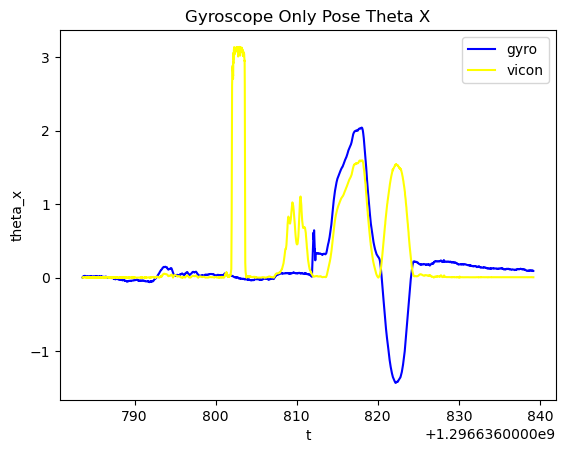

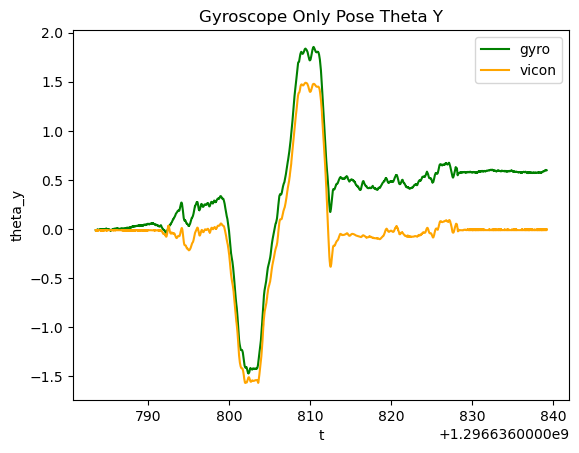

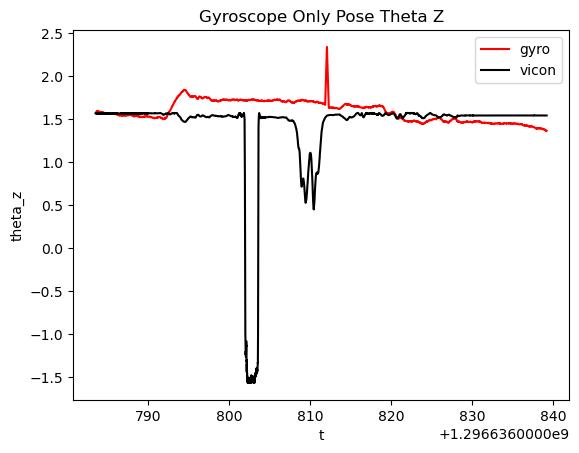

start Vicon Data: [ 0.00163043 -0.01125011  1.56623806]
start gyro Pose: [ 0.00163043 -0.01125011  1.56623806]
end Vicon Data: [ 0.00497656 -0.00259842  1.54044588]
end gyro Pose: [0.09274022 0.59821315 1.36144744]
Initial orientation for Accel Pose: [ 0.00163043 -0.01125011  1.56623806]
Accelerometer Bias in SI -> x:-54795.93518279731 | y:-53538.07833604752 | z:67229.87075014855
Last Value: [ 0.00163043 -0.01125011  1.56623806]
t: 0.012943029403686523
Last Value: [-0.04798806 -0.01221026  1.49631136]
t: 0.011852025985717773
Last Value: [-0.09302639 -0.013418    1.43271613]
t: 0.009372949600219727
Last Value: [-0.12895208 -0.01393902  1.38262529]
t: 0.012025117874145508
Last Value: [-0.17480996 -0.01466725  1.31749625]
t: 0.008443832397460938
Last Value: [-0.20710699 -0.01516324  1.27222434]
t: 0.010246992111206055
Last Value: [-0.24619299 -0.01566372  1.21718691]
t: 0.017325162887573242
Last Value: [-0.31258187 -0.01744955  1.12400923]
t: 0.009970903396606445
Last Value: [-0.3502884  

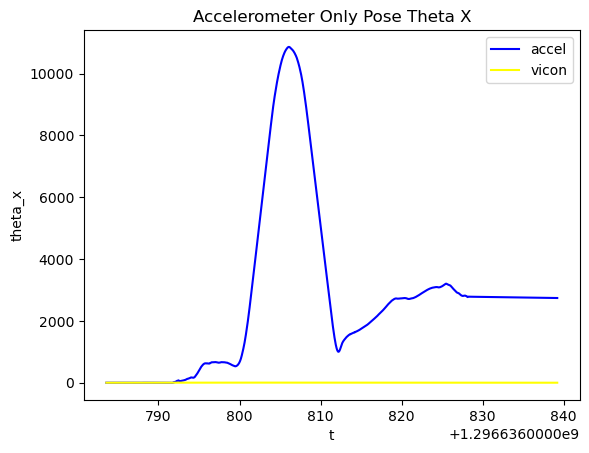

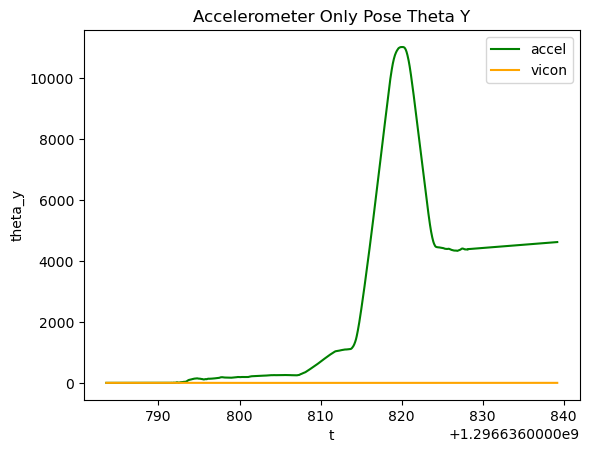

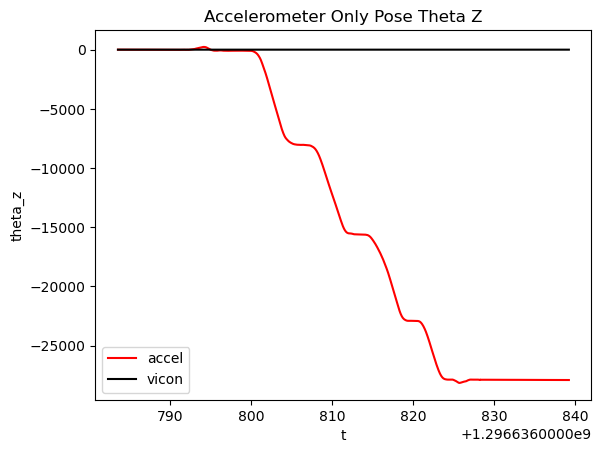

start Vicon Data: [ 0.00163043 -0.01125011  1.56623806]
start accel Pose: [ 0.00163043 -0.01125011  1.56623806]
end Vicon Data: [ 0.00497656 -0.00259842  1.54044588]
end accel Pose: [  2739.52304738   4625.01069093 -27905.51373013]


In [195]:
set1 = calculatePose(
    "Phase1/Data/Train/Vicon/viconRot1.mat",
    "Phase1/Data/Train/IMU/imuRaw1.mat",
    "Phase1/IMUParams.mat",
    "Set 1"
)

# set2 = calculatePose(
#     "Phase1/Data/Train/Vicon/viconRot2.mat",
#     "Phase1/Data/Train/IMU/imuRaw2.mat",
#     "Phase1/IMUParams.mat",
# )

# set3 = calculatePose(
#     "Phase1/Data/Train/Vicon/viconRot3.mat",
#     "Phase1/Data/Train/IMU/imuRaw3.mat",
#     "Phase1/IMUParams.mat",
# )

# set4 = calculatePose(
#     "Phase1/Data/Train/Vicon/viconRot4.mat",
#     "Phase1/Data/Train/IMU/imuRaw4.mat",
#     "Phase1/IMUParams.mat",
# )

# set5 = calculatePose(
#     "Phase1/Data/Train/Vicon/viconRot5.mat",
#     "Phase1/Data/Train/IMU/imuRaw5.mat",
#     "Phase1/IMUParams.mat",
# )

# set6 = calculatePose(
#     "Phase1/Data/Train/Vicon/viconRot6.mat",
#     "Phase1/Data/Train/IMU/imuRaw6.mat",
#     "Phase1/IMUParams.mat",
# )